<center><img src="https://i.ibb.co/9Z8Yb4P/Hope-fml401-logo-04.png" alt="LHU logo" width="120"><br/>
<strong style="font-size: 22px;">Machine Learning Models for Probability Classification in Spectrographic EEG Seizures Dataset</strong><br><br>Artificial Intelligence  © LHU, Denis Manolescu. 2024<br>@ Prof. Dr Neil Buckley<br><br></center>

# Abstract

> Significance: Electroencephalogram (EEG) analysis for seizure detection poses significant challenges due to the complex nature of brain signals. Deep learning models offer the potential to automate this complex process, but their accuracy and reliability remain key challenges.

> Aim and Approach: This study aims to enhance EEG seizure probability classification by integrating transfer learning with EfficientNetV2 architectures (EfficientNetV2S and EfficientNetV2B2), specialized convolutional layers, Long Short-Term Memory (LSTM) units, and fine-tuned attention mechanisms. This approach leverages the strengths of pre-trained models while customizing layers to capture the EEG's intricate patterns.

> Results & Conclusions: The top-performing model achieved 86.45% accuracy with a Kullback-Leibler Divergence loss of 0.95, demonstrating its capacity for accurate and confident seizure predictions. Integrating convolutional and LSTM layers improved performance, effectively capturing spatial-temporal patterns in EEG data. While attention mechanisms offered benefits, hardware limitations were also observed with increasing model complexity. These findings underscore the importance of model customisation against specific dataset characteristics and computational constraints.


**Note**: This notebook need to run on GPU. Is recommended T4 x2.

# 🛠 | Install Libraries  

Internet access is **disabled** during inference, preventing the usual `!pip install <lib_name>` method for library installation. For this reason, installation must occur from local files. In the next cell, libraries will be installed using local file paths, altering the code to `!pip install <local_filepath>`.

In [1]:
!pip install -q /kaggle/input/kerasv3-lib-ds/keras_cv-0.8.2-py3-none-any.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/keras-3.0.4-py3-none-any.whl --no-deps

# 📚 | Import Libraries 

In [3]:
import os
# Set Keras backend 
os.environ["KERAS_BACKEND"] = "jax"

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2  # OpenCV for image processing
import pandas as pd  # Pandas for data manipulation
import numpy as np  # NumPy for numerical computations
from glob import glob  # Glob for file path pattern matching
from tqdm.notebook import tqdm  # Tqdm for progress bars in notebooks
import joblib  # Joblib for efficient saving and loading of models

import matplotlib.pyplot as plt  # Matplotlib for plotting

## Check Library Versions

In [4]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.15.0
Keras: 3.0.4
KerasCV: 0.8.2


# ⚙️ | Configuration

In [5]:
class CFG:
    verbose = 1  # Control verbosity level
    seed = 42  # Seed for reproducibility
    #preset = "efficientnetv2_b2_imagenet" # First Baseline
    preset = "efficientnetv2_s_imagenet"   # Second BAseline
    image_size = [400, 300]  # Image dimensions (width, height)
    epochs = 13  # Number of training epochs
    batch_size = 64  # Training batch size
    lr_mode = "cos"  # Learning rate scheduler mode
    drop_remainder = True  # Drop last batch if smaller than batch_size
    num_classes = 6  # Total classes in dataset
    fold = 0  # Validation fold number
    class_names = ['Seizure', 'LPD', 'GPD', 'LRDA', 'GRDA', 'Other']  # Class labels
    label2name = dict(enumerate(class_names))  # Label to name mapping
    name2label = {v: k for k, v in label2name.items()}  # Name to label mapping

# # # ♻️ | Reproducibility 

In [6]:
keras.utils.set_random_seed(CFG.seed) # Sets value for random seed to produce similar result in each run.

# 📁 | Dataset Path 

In [7]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"  # Dataset source path

SPEC_DIR = "/tmp/dataset/hms-hbac"  # Target directory for spectrograms
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)  # Create train spectrogram directory
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)  # Create test spectrogram directory

# 📖 | Meta Data 

In [8]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv') # Load training data
# Assign paths to EEG and spectrogram files
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{SPEC_DIR}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy() # Copy expert consensus to class_name
df['class_label'] = df.expert_consensus.map(CFG.name2label) # Map class names to labels
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv') # Load test data
test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{SPEC_DIR}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0


,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec2_path
0,853520,3911565283,6885,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/test_spectrograms/853520...


## Convert `.parquet` to `.npy`

Converting EEG spectrograms from parquet to npy format simplifies data loading. This step changes the file format without modifying the content. Also removing the time column from spectrogram data.

In [8]:
# Define a function to process a single eeg_id
def process_spec(spec_id, split="train"):
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()

# Parallelize the processing using joblib for training data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids, total=len(spec_ids))
)

# Get unique spec_ids of test data
test_spec_ids = test_df["spectrogram_id"].unique()

# Parallelize the processing using joblib for test data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "test")
    for spec_id in tqdm(test_spec_ids, total=len(test_spec_ids))
)

  0%|          | 0/11138 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

# 🍚 | DataLoader

The DataLoader reads npy spectrogram files, extracts labeled subsamples with offset values, converts data into log spectrogram, and applies MixUp augmentation. It also converts mono channel signals to 3-channel to use "ImageNet" pretrained model weights.

In [9]:
# This function builds and returns an augmentation function that applies a series of image augmentations,
# including MixUp and RandomCutout, to improve model generalization. It's designed to work with image data, 
# enhancing the dataset's diversity and helping the model to learn more robust features from variations of the input data.

def build_augmenter(dim=CFG.image_size): # Define a list of augmentations to be applied
    augmenters = [
        keras_cv.layers.MixUp(alpha=2.0),# MixUp augmentation for blending images
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.1)), # Frequency masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # Time masking
    ]
    
    def augment(img, label): # Function to apply selected augmentations to the images
        data = {"images":img, "labels":label} # Prepare data dictionary
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.5: # With 50% chance, apply augmentation
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size, dtype=32):
    def decode_signal(path, offset=None):
        # Load .npy file, decode and process the signal
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])
        
        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None: 
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]
            
            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])
        
        # Convert to log spectrogram
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)
        
        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6
        
        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig
    
    def decode_label(label): # Encode label as one-hot vector
        label = tf.one_hot(label, CFG.num_classes)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.num_classes])
        return label
    
    def decode_with_labels(path, offset=None, label=None):
        # Decode both signal and label for labeled dataset
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)
    
    return decode_with_labels if with_labels else decode_signal


def build_dataset(paths, offsets=None, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=False, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    # Create cache directory if caching is enabled and a directory is specified
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    # Use default decoder function if not provided
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    # Use default augmentation function if not provided
    if augment_fn is None:
        augment_fn = build_augmenter()
    # Prepare dataset slices based on provided data
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices) # Create dataset from slices
    ds = ds.map(decode_fn, num_parallel_calls=AUTO) # Decode data
    ds = ds.cache(cache_dir) if cache else ds # Cache dataset if enabled
    ds = ds.repeat() if repeat else ds # Repeat dataset if enabled
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False # Non-deterministic for shuffling
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder) # Batch dataset
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO) # Prefetch data for efficiency
    return ds # Returns a tf.data.Dataset ready for training or evaluation, with optional caching, augmentation, and shuffling

# 🔪 | Data Split

Divides data into `5` folds, preventing patient overlap between training and validation sets with the `groups` argument to avoid **data leakage**. Stratifies each split by `class_label` for uniform class distribution in every fold.

In [10]:
from sklearn.model_selection import StratifiedGroupKFold
# Initialize stratified group k-fold
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

df["fold"] = -1 # Initialize fold column
df.reset_index(drop=True, inplace=True) # Reset index for consistent indexing
# Assign fold numbers ensuring no patient overlap and stratified class distribution
for fold, (train_idx, valid_idx) in enumerate(
    sgkf.split(df, y=df["class_label"], groups=df["patient_id"])
):
    df.loc[valid_idx, "fold"] = fold
    
# Display count of eeg_ids by fold and class for verification
df.groupby(["fold", "class_name"])[["eeg_id"]].count().T

fold           0                                     1                    ...  \
class_name   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA  ...   
eeg_id      2050  2605  1168  3793  3462    4007  4832  4856  4463  3117  ...   

fold           3                         4                                  
class_name   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure  
eeg_id      2318  4296  3884    4787  1889  3700  4249  3002  4013    4045  

[1 rows x 30 columns]

## Data Partitioning: Build Train & Valid Dataset

Only first sample for each `spectrogram_id` is used in order to keep the dataset size managable. Increasing the `HEAD` triggers OoM errors.

In [11]:
# Sample # Sampling unique spectrogram entries from full data
sample_df = df.groupby("spectrogram_id").head(1).reset_index(drop=True)
#sample_df = df.groupby("spectrogram_id").reset_index(drop=True) # no subsampling

# Split into training and validation based on fold
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Setup training dataset
train_paths = train_df.spec2_path.values
train_offsets = train_df.spectrogram_label_offset_seconds.values.astype(int)
train_labels = train_df.class_label.values
# Build training dataset with augmentation and shuffling
train_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=True)

# Setup validation dataset
valid_paths = valid_df.spec2_path.values
valid_offsets = valid_df.spectrogram_label_offset_seconds.values.astype(int)
valid_labels = valid_df.class_label.values
# Build validation dataset without augmentation or shuffling
valid_ds = build_dataset(valid_paths, valid_offsets, valid_labels, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=True)

# Num Train: 9166 | Num Valid: 1972


## Dataset Check

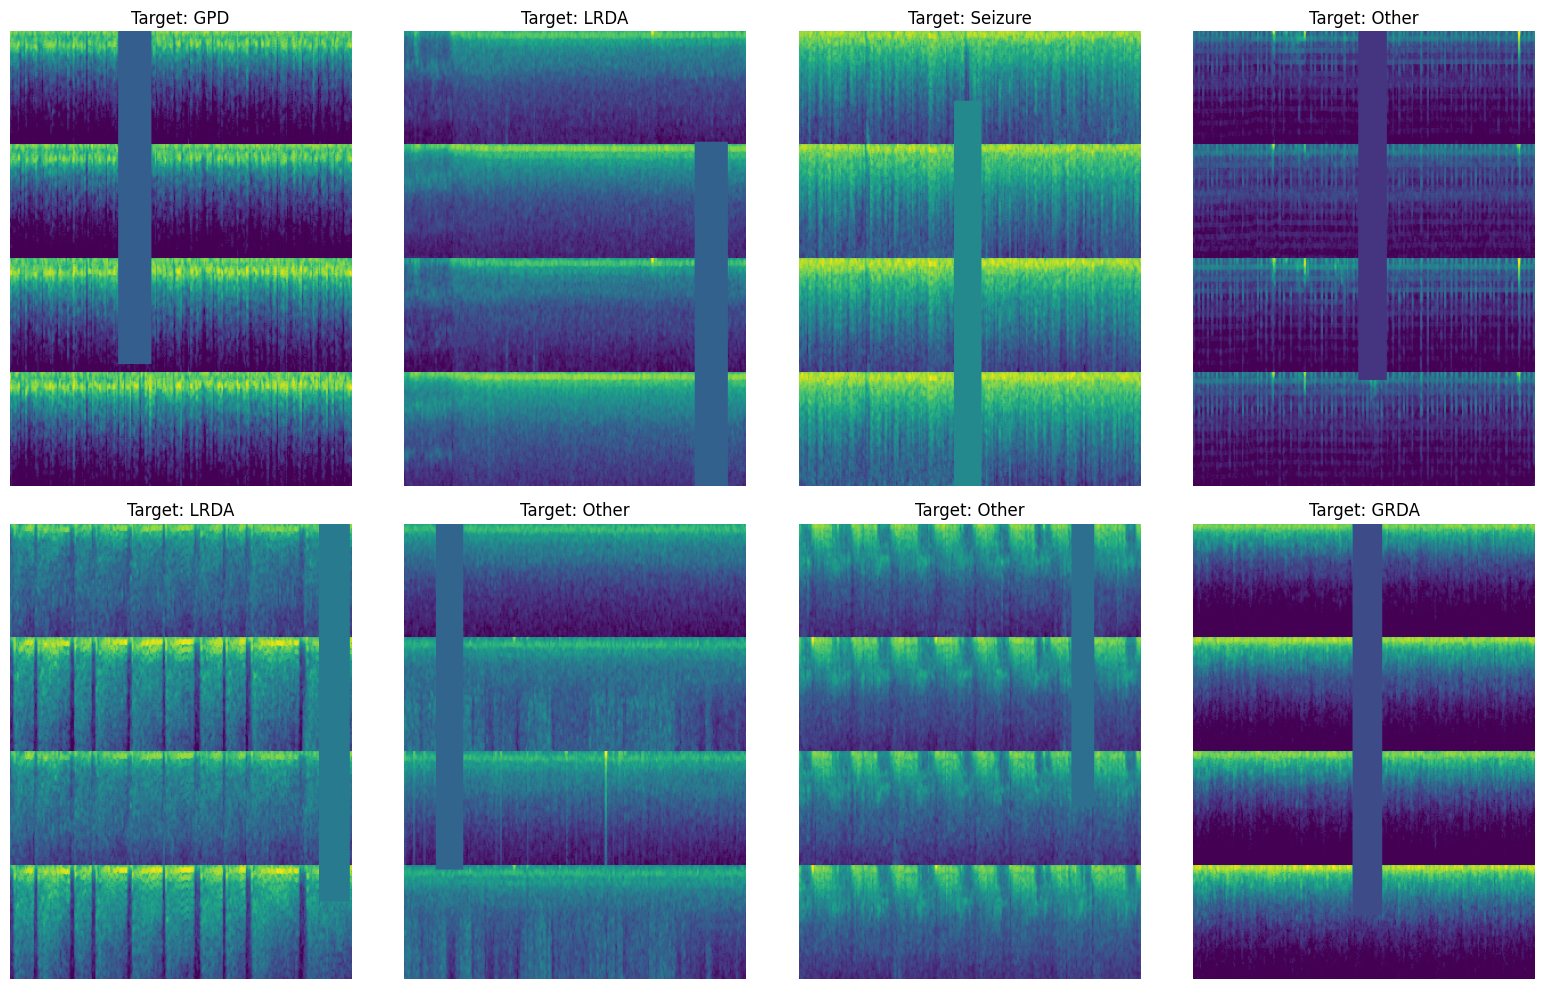

In [12]:
# Fetch a batch from the training dataset
imgs, tars = next(iter(train_ds))

num_imgs = 8
plt.figure(figsize=(4*4, num_imgs//4*5))
for i in range(num_imgs):
    plt.subplot(num_imgs//4, 4, i + 1)
    img = imgs[i].numpy()[...,0]  # Adjust as per your image data format
    img -= img.min()
    img /= img.max() + 1e-4 # Prevent division by zero
    # Decode target label
    tar = CFG.label2name[np.argmax(tars[i].numpy())]
    plt.imshow(img)
    plt.title(f"Target: {tar}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# 🔍 | Loss & Metric

The evaluation metric in this competition is **KL Divergence**, defined as,

$$
D_{\text{KL}}(P \parallel Q) = \sum_{i} P(i) \log\left(\frac{P(i)}{Q(i)}\right)
$$

Where:
- $P$ is the true distribution.
- $Q$ is the predicted distribution.

**KL Divergence**, being differentiable, serves directly as our loss function, eliminating the need for third-party metrics like **Accuracy** for model evaluation. Thus, `valid_loss` alone indicates performance. Keras already includes a KL Divergence loss implementation, so we simply import it.

In [13]:
LOSS = keras.losses.KLDivergence() # Set loss function to Kullback-Leibler Divergence

# 🤖 | Modeling

This notebook uses the `EfficientNetV2 B2 and S` from KerasCV's collection of pretrained models.

## Important NOTE:
## 🤖 | To execute one of the **Baselines** from CFG skip Modelling step, as is already loaded & jump to ⚓ | LR Schedule

In [ ]:
# 2. Model with simple Attention Mechanism
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Multiply
from tensorflow.keras.models import Model
import tensorflow as tf

def build_custom_cnn_with_attention(input_shape, num_classes, fine_tune=False):
    # Load the base model with pre-downloaded weights
    base_model = EfficientNetV2B2(include_top=False, weights='/kaggle/input/efficientnetv2-b2-imgnet-notop/efficientnetv2-b2_imagenet_notop.h5', input_shape=input_shape, pooling=None)
    
    # Decide on the trainability of the base model
    base_model.trainable = fine_tune

    # Base model output
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Ensure the output is a 1D feature vector

    # Implementing simple attention mechanism for 1D feature vector
    attention_probs = Dense(units=x.shape[-1], activation='softmax', name='attention_vec')(x)
    x = Multiply()([x, attention_probs])
    
    # Proceed with custom top layers
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Example usage
model = build_custom_cnn_with_attention(input_shape=(400, 300, 3), num_classes=6, fine_tune=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS,  # Kullback-Leibler Divergence loss
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# To view the model summary
# model.summary() # avoid this because the backbone is large arhitecture

In [ ]:
# 3. Model with simple Attention Mechanism
from tensorflow.keras.layers import Reshape, MultiHeadAttention, LayerNormalization, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B2
import tensorflow as tf

def build_custom_cnn_with_multihead_attention(input_shape, num_classes, fine_tune=False):
    # Load the base model with pre-downloaded weights
    base_model = EfficientNetV2B2(include_top=False, weights='/kaggle/input/efficientnetv2-b2-imgnet-notop/efficientnetv2-b2_imagenet_notop.h5', input_shape=input_shape, pooling=None)
    
    # Decide on the trainability of the base model
    base_model.trainable = fine_tune

    # Base model output before pooling
    x = base_model.output
    
    # Calculate the sequence length, which is height times width, for reshaping
    height, width = 13, 10  # Extracted from the model summary image
    seq_length = height * width
    channels = base_model.output_shape[-1]  # 1408 channels
    
    # Reshape x to (batch_size, seq_length, channels)
    x = Reshape((seq_length, channels))(x)
    
    # Implementing multi-head attention mechanism
    #attention_output = MultiHeadAttention(num_heads=4, key_dim=channels)(x, x)
     attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x) #more heads test
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)
    
    # Optionally, apply a pooling layer or another reshaping here if needed
    # Here we use GlobalAveragePooling1D to reduce the sequence to a vector
    x = GlobalAveragePooling1D()(attention_output)
    
    # Proceed with custom top layers
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Example usage
model = build_custom_cnn_with_multihead_attention(input_shape=(400, 300, 3), num_classes=6, fine_tune=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.KLDivergence(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# To view the model summary
# model.summary()

In [ ]:
# 4. Model with simple Attention Mechanism and more heads
from tensorflow.keras.layers import Reshape, MultiHeadAttention, LayerNormalization, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B2
import tensorflow as tf

def build_custom_cnn_with_multihead_attention(input_shape, num_classes, fine_tune=False):
    # Load the base model with pre-downloaded weights
    base_model = EfficientNetV2B2(include_top=False, weights='/kaggle/input/efficientnetv2-b2-imgnet-notop/efficientnetv2-b2_imagenet_notop.h5', input_shape=input_shape, pooling=None)
    
    # Decide on the trainability of the base model
    base_model.trainable = fine_tune

    # Base model output before pooling
    x = base_model.output
    
    # Calculate the sequence length, which is height times width, for reshaping
    height, width = 13, 10  # Extracted from the model summary image
    seq_length = height * width
    channels = base_model.output_shape[-1]  # 1408 channels
    
    # Reshape x to (batch_size, seq_length, channels)
    x = Reshape((seq_length, channels))(x)
    
    # Implementing multi-head attention mechanism
    #attention_output = MultiHeadAttention(num_heads=4, key_dim=channels)(x, x)
    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x) #more heads test
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)
    
    # Optionally, apply a pooling layer or another reshaping here if needed
    # Here we use GlobalAveragePooling1D to reduce the sequence to a vector
    x = GlobalAveragePooling1D()(attention_output)
    
    # Proceed with custom top layers
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Example usage
model = build_custom_cnn_with_multihead_attention(input_shape=(400, 300, 3), num_classes=6, fine_tune=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.KLDivergence(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# To view the model summary
# model.summary()

In [ ]:
# 5. Model with simple Attention Mechanism and value & key _dim
from tensorflow.keras.layers import Reshape, MultiHeadAttention, LayerNormalization, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B2
import tensorflow as tf

def build_custom_cnn_with_multihead_attention(input_shape, num_classes, fine_tune=False):
    # Load the base model with pre-downloaded weights
    base_model = EfficientNetV2B2(include_top=False, weights='/kaggle/input/efficientnetv2-b2-imgnet-notop/efficientnetv2-b2_imagenet_notop.h5', input_shape=input_shape, pooling=None)
    
    # Decide on the trainability of the base model
    base_model.trainable = fine_tune

    # Base model output before pooling
    x = base_model.output
    
    # Calculate the sequence length, which is height times width, for reshaping
    height, width = 13, 10  # Extracted from the model summary image
    seq_length = height * width
    channels = base_model.output_shape[-1]  # 1408 channels
    
    # Reshape x to (batch_size, seq_length, channels)
    x = Reshape((seq_length, channels))(x)
    
    key_dim = 2816  # Example key dimension size
    value_dim = 2816
    # Implementing more key, value _dim
    attention_output = MultiHeadAttention(num_heads=4, key_dim=key_dim, value_dim=value_dim)(x, x)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)
    
    # Optionally, apply a pooling layer or another reshaping here if needed
    # Here we use GlobalAveragePooling1D to reduce the sequence to a vector
    x = GlobalAveragePooling1D()(attention_output)
    
    # Proceed with custom top layers
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Example usage
model = build_custom_cnn_with_multihead_attention(input_shape=(400, 300, 3), num_classes=6, fine_tune=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.KLDivergence(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# To view the model summary
# model.summary()

In [ ]:
# 6. Model with simple Attention Mechanism and multiple attention blocks
from tensorflow.keras.layers import Reshape, MultiHeadAttention, LayerNormalization, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B2
import tensorflow as tf

def build_custom_cnn_with_multihead_attention_and_blocks(input_shape, num_classes, fine_tune=False):
    # Load the base model with pre-downloaded weights
    base_model = EfficientNetV2B2(include_top=False, weights='/kaggle/input/efficientnetv2-b2-imgnet-notop/efficientnetv2-b2_imagenet_notop.h5', input_shape=input_shape, pooling=None)
    
    # Decide on the trainability of the base model
    base_model.trainable = fine_tune

    # Base model output before pooling
    x = base_model.output
    
    # Calculate the sequence length, which is height times width, for reshaping
    height, width = 13, 10
    seq_length = height * width
    channels = base_model.output_shape[-1]  # 1408 channels
    
    # Reshape x to (batch_size, seq_length, channels)
    x = Reshape((seq_length, channels))(x)
    
    # Implementing 3 multi-head attention mechanism blocks
    for _ in range(2):  # Number of attention blocks <<< DO IT AGAIN WITH 2/3
        attention_output = MultiHeadAttention(num_heads=4, key_dim=channels)(x, x)
        x = LayerNormalization(epsilon=1e-6)(attention_output + x)  # Apply skip connection and normalization
    
    # After the last attention block, apply GlobalAveragePooling1D
    x = GlobalAveragePooling1D()(x)
    
    # Proceed with custom top layers
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Example usage
model = build_custom_cnn_with_multihead_attention_and_blocks(input_shape=(400, 300, 3), num_classes=6, fine_tune=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS,
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# To view the model summary
# model.summary()

In [ ]:
# 7. Model with Attention Mechanism, doubleHeads & double value-key _dim
from tensorflow.keras.layers import Reshape, MultiHeadAttention, LayerNormalization, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B2
import tensorflow as tf

def build_custom_cnn_with_multihead_attention(input_shape, num_classes, fine_tune=False):
    # Load the base model with pre-downloaded weights
    base_model = EfficientNetV2B2(include_top=False, weights='/kaggle/input/efficientnetv2-b2-imgnet-notop/efficientnetv2-b2_imagenet_notop.h5', input_shape=input_shape, pooling=None)
    
    # Decide on the trainability of the base model
    base_model.trainable = fine_tune

    # Base model output before pooling
    x = base_model.output
    
    # Calculate the sequence length, which is height times width, for reshaping
    height, width = 13, 10  # Extracted from the model summary image
    seq_length = height * width
    channels = base_model.output_shape[-1]  # 1408 channels
    
    # Reshape x to (batch_size, seq_length, channels)
    x = Reshape((seq_length, channels))(x)
    
    key_dim = 2816  # Example key dimension size
    value_dim = 2816
    # Implementing more key, value _dim
    attention_output = MultiHeadAttention(num_heads=8, key_dim=key_dim, value_dim=value_dim)(x, x)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)
    
    # Optionally, apply a pooling layer or another reshaping here if needed
    # Here we use GlobalAveragePooling1D to reduce the sequence to a vector
    x = GlobalAveragePooling1D()(attention_output)
    
    # Proceed with custom top layers
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Example usage
model = build_custom_cnn_with_multihead_attention(input_shape=(400, 300, 3), num_classes=6, fine_tune=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.KLDivergence(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# To view the model summary
# model.summary()

In [ ]:
# 8. Model with Attention Mechanism, 3x value-key _dim + 6Heads
from tensorflow.keras.layers import Reshape, MultiHeadAttention, LayerNormalization, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B2
import tensorflow as tf

def build_custom_cnn_with_multihead_attention(input_shape, num_classes, fine_tune=False):
    # Load the base model with pre-downloaded weights
    base_model = EfficientNetV2B2(include_top=False, weights='/kaggle/input/efficientnetv2-b2-imgnet-notop/efficientnetv2-b2_imagenet_notop.h5', input_shape=input_shape, pooling=None)
    
    # Decide on the trainability of the base model
    base_model.trainable = fine_tune

    # Base model output before pooling
    x = base_model.output
    
    # Calculate the sequence length, which is height times width, for reshaping
    height, width = 13, 10  # Extracted from the model summary image
    seq_length = height * width
    channels = base_model.output_shape[-1]  # 1408 channels
    
    # Reshape x to (batch_size, seq_length, channels)
    x = Reshape((seq_length, channels))(x)
    
    key_dim = 4224  # Example key dimension size
    value_dim = 4224
    # Implementing more key, value _dim
    attention_output = MultiHeadAttention(num_heads=4, key_dim=key_dim, value_dim=value_dim)(x, x)
    # Apply Dropout before LayerNormalization (potentially better regularization)
    attention_output = Dropout(0.2)(attention_output) 
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)
    
    # Optionally, apply a pooling layer or another reshaping here if needed
    # Here we use GlobalAveragePooling1D to reduce the sequence to a vector
    x = GlobalAveragePooling1D()(attention_output)
    
    # Proceed with custom top layers
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Example usage
model = build_custom_cnn_with_multihead_attention(input_shape=(400, 300, 3), num_classes=6, fine_tune=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.KLDivergence(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# To view the model summary
# model.summary()

In [ ]:
# 9 EfficentNetV2S with 2 convolution layers CNN + RNN
# BEST PERFORMANCE MODEL
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, ReLU, BatchNormalization, Reshape, LSTM
import tensorflow as tf

def build_custom_cnn(input_shape, num_classes, fine_tune=False):
    # Load the base model with pre-downloaded weights
    base_model = EfficientNetV2S(include_top=False, weights='/kaggle/input/efficientnetv2-s-imagenet-notop/efficientnetv2-s_imagenet_notop.h5', input_shape=input_shape)#, pooling='avg')
    # Decide on the trainability of the base model
    base_model.trainable = fine_tune  # Set to True to fine-tune the entire model

    # Starting from the base model's output
    x = base_model.output
    
   # Adding a new CNN block
    # Ensure that the kernel size, strides, and pooling sizes are such that the feature map does not get reduced to less than 1x1
    x = Conv2D(filters=32, kernel_size=(1, 1), activation='relu')(x)  # using 1x1 convolutions
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(1, 1), activation='relu')(x)  # using 1x1 convolutions
    x = BatchNormalization()(x)
    x = Conv2D(filters=16, kernel_size=(1, 1), activation='relu')(x)  # using 1x1 convolutions
    x = BatchNormalization()(x)
    
    ## Testing an RNN - long shoot
    x = Reshape((-1, x.shape[1] * x.shape[3]))(x) # Treats flattened spatial as steps
    # RNN layer introduction – let's use LSTM as an example
    x = LSTM(units=64)(x)
    
    # Continue with the original custom top layers
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Example usage
model = build_custom_cnn(input_shape=(400, 300, 3), num_classes=6, fine_tune=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
              loss=LOSS,
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# To view the model summary
# model.summary()

In [ ]:
# 10 EfficientNetV2B2 with 3 convolution layers CNN
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, ReLU, BatchNormalization, Reshape, LSTM
import tensorflow as tf

def build_custom_cnn(input_shape, num_classes, fine_tune=False):
    # Load the base model with pre-downloaded weights
    base_model = EfficientNetV2B2(include_top=False, weights='/kaggle/input/efficientnetv2-b2-imgnet-notop/efficientnetv2-b2_imagenet_notop.h5', input_shape=input_shape)#, pooling='avg')
    # Decide on the trainability of the base model
    base_model.trainable = fine_tune  # Set to True to fine-tune the entire model

    # Starting from the base model's output
    x = base_model.output
    
   # Adding a new CNN block
    # Ensure that the kernel size, strides, and pooling sizes are such that the feature map does not get reduced to less than 1x1
    x = Conv2D(filters=32, kernel_size=(1, 1), activation='relu')(x)  # using 1x1 convolutions
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(1, 1), activation='relu')(x)  # using 1x1 convolutions
    x = BatchNormalization()(x)
    x = Conv2D(filters=16, kernel_size=(1, 1), activation='relu')(x)  # using 1x1 convolutions
    x = BatchNormalization()(x)
    
    ## Testing an RNN - long shoot
    x = Reshape((-1, x.shape[1] * x.shape[3]))(x) # Treats flattened spatial as steps
    # RNN layer introduction – let's use LSTM as an example
    x = LSTM(units=64)(x)
    
    # Continue with the original custom top layers
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Example usage
model = build_custom_cnn(input_shape=(400, 300, 3), num_classes=6, fine_tune=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
              loss=LOSS,
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# To view the model summary
#model.summary()

In [ ]:
# 11. Base with pointwise CNN & RNN + Attention Mechanism with value-key _dim
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape,
    LSTM, Flatten, Dense, Dropout, GlobalAveragePooling1D,
    MultiHeadAttention, LayerNormalization
)
import tensorflow as tf

def build_custom_cnn(input_shape, num_classes, fine_tune=False):
    # Load the base model with pre-downloaded weights
    base_model = EfficientNetV2B2(include_top=False, weights='/kaggle/input/efficientnetv2-b2-imgnet-notop/efficientnetv2-b2_imagenet_notop.h5', input_shape=input_shape)
    # Decide on the trainability of the base model
    base_model.trainable = fine_tune

    # Starting from the base model's output
    x = base_model.output

    # Adding a new CNN block
    x = Conv2D(filters=32, kernel_size=(1, 1), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(1, 1), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=16, kernel_size=(1, 1), activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Reshape for attention mechanism
    # Assuming the conv layers end with shape (None, height, width, channels)
    # Treat each spatial location as a sequence element
    seq_length = x.shape[1] * x.shape[2]
    channels = x.shape[3]
    x = Reshape((seq_length, channels))(x)

    # Apply MultiHeadAttention
    key_dim = 1408  
    value_dim = 1408
    attention_output = MultiHeadAttention(num_heads=4, key_dim=key_dim, value_dim=value_dim)(x, x)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)

    # Apply RNN - LSTM layer to the output of the attention mechanism
    x = LSTM(units=64)(attention_output)

    # Continue with the original custom top layers
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Example usage
model = build_custom_cnn(input_shape=(400, 300, 3), num_classes=6, fine_tune=True)
LOSS = 'categorical_crossentropy'  # Make sure LOSS is defined or replace it with a string
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS,
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# To view the model summary
#model.summary()


In [ ]:
# 12. Base with CNN + RNN + Attention Mechanism with value-key _dim
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape,
    LSTM, Flatten, Dense, Dropout, GlobalAveragePooling1D,
    MultiHeadAttention, LayerNormalization
)
import tensorflow as tf

def build_custom_cnn(input_shape, num_classes, fine_tune=False):
    # Load the base model with pre-downloaded weights
    base_model = EfficientNetV2B2(include_top=False, weights='/kaggle/input/efficientnetv2-b2-imgnet-notop/efficientnetv2-b2_imagenet_notop.h5', input_shape=input_shape, pooling=None)
    # Decide on the trainability of the base model
    base_model.trainable = fine_tune

    # Starting from the base model's output
    x = base_model.output

    # Adding a new CNN block
    # Adding two convolutional layers with larger kernel sizes
    # Padding is 'same' to keep the spatial dimensions unchanged
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    # Now x will have shape (None, 13, 10, 64), assuming 64 is the number of filters in the last conv layer
    # Reshape x to (batch_size, sequence_length, features) for the RNN layer
    # We treat the spatial dimensions (height and width) as the sequence
    sequence_length = 13 * 10  # Each position in the spatial grid is a time step in the sequence
    features = 64  # This is the number of filters in the last convolutional layer
    x = Reshape((sequence_length, features))(x)

    # Add the RNN layer
    x = LSTM(units=64)(x)
    
    # Flatten the output of the LSTM to connect it to Dense layers
    x = Flatten()(x)

    # LayerNormalization can be applied here after LSTM if necessary
    x = LayerNormalization(epsilon=1e-6)(x)

    # Continue with custom top layers
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

model = build_custom_cnn(input_shape=(400, 300, 3), num_classes=6, fine_tune=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS,
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# To view the model summary
#model.summary()


In [ ]:
# 13. Base with CNN & RNN + Attention Mechanism with value-key _dim
# SECOND BEST PERFORMANCE MODEL
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape,
    LSTM, Flatten, Dense, Dropout, GlobalAveragePooling1D,
    MultiHeadAttention, LayerNormalization
)
import tensorflow as tf

def build_custom_cnn(input_shape, num_classes, fine_tune=False):
    # Load the base model with pre-downloaded weights
    base_model = EfficientNetV2B2(include_top=False, weights='/kaggle/input/efficientnetv2-b2-imgnet-notop/efficientnetv2-b2_imagenet_notop.h5', input_shape=input_shape, pooling=None)
    # Decide on the trainability of the base model
    base_model.trainable = fine_tune

    # Starting from the base model's output
    x = base_model.output

    # Adding a new CNN block
    # Adding two convolutional layers with larger kernel sizes
    # Padding is 'same' to keep the spatial dimensions unchanged
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    # Now x will have shape (None, 13, 10, 64), assuming 64 is the number of filters in the last conv layer
    # Reshape x to (batch_size, sequence_length, features) for the RNN layer
    # We treat the spatial dimensions (height and width) as the sequence
    sequence_length = 13 * 10  # Each position in the spatial grid is a time step in the sequence
    features = 64  # This is the number of filters in the last convolutional layer
    x = Reshape((sequence_length, features))(x)

    # Add the RNN layer
    x = LSTM(units=64, return_sequences=True)(x)  # Set return_sequences=True to keep the sequence structure
    
    # Apply MultiHeadAttention
    key_dim = 2816  #1408 key dimensions for the attention mechanism
    value_dim = 2816  #1408 value dimensions for the attention mechanism
    attention_output = MultiHeadAttention(num_heads=6, key_dim=key_dim, value_dim=value_dim)(x, x)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)

    # Apply GlobalAveragePooling1D to reduce the sequence of attention outputs to a single vector
    x = GlobalAveragePooling1D()(attention_output)

    # Continue with custom top layers
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

model = build_custom_cnn(input_shape=(400, 300, 3), num_classes=6, fine_tune=True) # heads changed from 4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS,
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# To view the model summary
#model.summary()


## You can SKIP the next 2 models, 14 and 15 from below [ for TEST only ]

In [ ]:
# 14. Model with Attention Mechanism, doubleHeads & double value-key _dim = NOT WORKING [reached some limits here] [ SKIP THIS MODEL]
from tensorflow.keras.layers import Reshape, MultiHeadAttention, LayerNormalization, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B2
import tensorflow as tf

def build_custom_cnn_with_multihead_attention(input_shape, num_classes, fine_tune=False):
    # Load the base model with pre-downloaded weights
    base_model = EfficientNetV2B2(include_top=False, weights='/kaggle/input/efficientnetv2-s-imagenet-notop/efficientnetv2-s_imagenet_notop.h5', input_shape=input_shape, pooling=None)
    
    # Decide on the trainability of the base model
    base_model.trainable = fine_tune

    # Base model output before pooling
    x = base_model.output
    
    # Calculate the sequence length, which is height times width, for reshaping
    height, width = 13, 10  # Extracted from the model summary image
    seq_length = height * width
    channels = base_model.output_shape[-1]  # 1408 channels
    
    # Reshape x to (batch_size, seq_length, channels)
    x = Reshape((seq_length, channels))(x)
    
    key_dim = 1000  # Example key dimension size
    value_dim = 1000
    # Implementing more key, value _dim
    attention_output = MultiHeadAttention(num_heads=3, key_dim=key_dim, value_dim=value_dim)(x, x)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)
    
    # Optionally, apply a pooling layer or another reshaping here if needed
    # Here we use GlobalAveragePooling1D to reduce the sequence to a vector
    x = GlobalAveragePooling1D()(attention_output)
    
    # Proceed with custom top layers
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Example usage
model = build_custom_cnn_with_multihead_attention(input_shape=(400, 300, 3), num_classes=6, fine_tune=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.KLDivergence(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# To view the model summary
#model.summary()

In [ ]:
# 15 EfficentNetV2S with CNN + RNN  [NOT included in the coursework, only for dev tests only] [ SKIP THIS MODEL ]
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape,
    LSTM, Flatten, Dense, Dropout, GlobalAveragePooling1D,
    MultiHeadAttention, LayerNormalization
)
import tensorflow as tf

def build_custom_cnn(input_shape, num_classes, fine_tune=False):
    # Load the base model with pre-downloaded weights
    base_model = EfficientNetV2B2(include_top=False, weights='/kaggle/input/efficientnetv2-b2-imgnet-notop/efficientnetv2-b2_imagenet_notop.h5', input_shape=input_shape, pooling=None)
    # Decide on the trainability of the base model
    base_model.trainable = fine_tune

    # Starting from the base model's output
    x = base_model.output

    # Adding a new CNN block
    # Adding two convolutional layers with larger kernel sizes
    # Padding is 'same' to keep the spatial dimensions unchanged
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    # Now x will have shape (None, 13, 10, 64), assuming 64 is the number of filters in the last conv layer
    # Reshape x to (batch_size, sequence_length, features) for the RNN layer
    # We treat the spatial dimensions (height and width) as the sequence
    sequence_length = 13 * 10  # Each position in the spatial grid is a time step in the sequence
    features = 64  # This is the number of filters in the last convolutional layer
    x = Reshape((sequence_length, features))(x)

    # Add the RNN layer
    x = LSTM(units=64)(x)
    
    # Flatten the output of the LSTM to connect it to Dense layers
    x = Flatten()(x)

    # LayerNormalization can be applied here after LSTM if necessary
    x = LayerNormalization(epsilon=1e-6)(x)

    # Continue with custom top layers
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

model = build_custom_cnn(input_shape=(400, 300, 3), num_classes=6, fine_tune=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS,
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# To view the model summary
#model.summary()

In [ ]:
## 17:30 New top define [ THIS is used for further tests - SKIP it PLEASE ]
from tensorflow.keras.applications import EfficientNetV2S #EfficientNetV2B2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
import tensorflow as tf

def build_custom_cnn(input_shape, num_classes, fine_tune=False):
    # Load the base model with pre-downloaded weights
    #base_model = EfficientNetV2B2(include_top=False, weights='/kaggle/input/efficientnetv2-b2-imgnet-notop/efficientnetv2-b2_imagenet_notop.h5', input_shape=input_shape, pooling='avg')
    base_model = EfficientNetV2S(include_top=False, weights='/kaggle/input/efficientnetv2-s-imagenet-notop/efficientnetv2-s_imagenet_notop.h5', input_shape=input_shape, pooling='avg')
    # Decide on the trainability of the base model
    base_model.trainable = fine_tune  # Set to True to fine-tune the entire model

    # Add custom top layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Example usage
model = build_custom_cnn(input_shape=(400, 300, 3), num_classes=6, fine_tune=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
              loss=LOSS,
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Model Summary to verify architecture
#model.summary()

## Get the last 5 layers of any model from above [ IF someone is interested ]:

In [ ]:
last_10_layers = model.layers[-5:]

# Print information about the last 10 layers
for layer in last_10_layers:
    # Use `.output.shape` for layers like Dropout that don't have `output_shape` directly
    output_shape = layer.output.shape if hasattr(layer, 'output') else 'Not available'
    print(layer.name, output_shape)

## AutoML Hyperparameter Tuner

In [ ]:
# 1. A - Define Hypermodel 
from kerastuner import HyperModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
                         kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
                         activation='relu',
                         input_shape=self.input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        # Add more layers based on your hyperparameter search space
        model.add(Flatten())
        model.add(Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=32),
                        activation='relu'))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),LOSS,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

In [ ]:
# 1. B = Hyperparameter Search
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    CNNHyperModel(input_shape=(400, 300, 3), num_classes=CFG.num_classes),
    objective='val_accuracy',
    max_trials=5,  # Set max_trials to a reasonable number to limit search time
    executions_per_trial=1,  # Adjust based on your computational resources
    directory='auto_model',  # Directory to store model architectures and weights
    project_name='eeg_classification'
)

tuner.search(train_ds, epochs=CFG.epochs, validation_data=valid_ds)

In [ ]:
#1. C - Hypermodel Training
best_model = tuner.get_best_models(num_models=1)[0]
# Now, you can train this model as you would with any other Keras model

## NEXT line Compiles any model chosen above

In [ ]:
# 0. Build Classifier - Base Model
model = keras_cv.models.ImageClassifier.from_preset(
    CFG.preset, num_classes=CFG.num_classes
)
#model = build_custom_cnn(input_shape=(400, 300, 3), num_classes=6)
# Compile the model  
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              #loss=LOSS)
# Now build and compile your custom model
#model = build_custom_cnn(input_shape=(400, 300, 3), num_classes=6)

model.compile(optimizer='adam',
              loss=LOSS,
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Model Summary
model.summary() # HERE we can see the added layer to to no-top base model + Total Parameters

# ⚓ | LR Schedule

A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [ ]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=12, plot=False):
    #lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_start, lr_max, lr_min = 5e-5, 5e-5 * batch_size, 1e-5  # Adjusted lr_max to be higher

    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

In [ ]:
lr_cb = get_lr_callback(CFG.batch_size, mode=CFG.lr_mode, plot=True)

# 💾 | Model Checkpointing

In [ ]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.keras",
                                         monitor='val_loss',  # Track validation loss
                                         save_best_only=True,  # Save only the best model
                                         save_weights_only=False,  # Save full model
                                         mode='min')  # Minimize validation loss

# 🚂 | Training

In [ ]:
# THIS IS ONLY FOR THE TUNER HYPERMODEL - SKIP to NEXT if you want to train any other 
from tensorflow import keras
from keras_tuner import RandomSearch
import tensorflow as tf

def build_model(hp):
    model = keras.Sequential()
    
    # Load the EfficientNetB2 model without the top layer and with pre-trained weights
    base_model = tf.keras.applications.EfficientNetB2(include_top=False, input_shape=(400, 300, 3), pooling='avg', weights=None)
    base_model.trainable = False
    
    model.add(base_model)  # The base model already includes global average pooling
    
    # You can tune the number of units in the Dense layer
    model.add(keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(6, activation='softmax'))  # Adjust the number of output classes
    
    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',  # Use KLDivergence if appropriate for your problem
                  metrics=['accuracy'])
    
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='eeg_classification'
)

# Assuming `train_ds` and `valid_ds` are already defined as per your data layout
# Ensure these datasets return (image, label) pairs and that labels are integer-encoded if using 'sparse_categorical_crossentropy'
steps_per_epoch = len(train_df) // CFG.batch_size
# Start the hyperparameter search
tuner.search(train_ds,
             steps_per_epoch=steps_per_epoch,
             epochs=5,
             validation_data=valid_ds, 
             validation_steps=len(valid_df) // CFG.batch_size)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Optionally, further train the best model with the entire dataset or evaluate it
best_model.evaluate(valid_ds)

## To TRAIN any model, except the Hypermodel, execute below

In [ ]:
# START Train
history = model.fit(
    train_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose
)

In [ ]:
# Get Metrics
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(valid_ds)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")

# 🧪 | Prediction

## Load Best Model

In [ ]:
model.load_weights("best_model.keras")

## Build Test Dataset

In [ ]:
test_paths = test_df.spec2_path.values
test_ds = build_dataset(test_paths, batch_size=min(CFG.batch_size, len(test_df)),
                         repeat=False, shuffle=False, cache=False, augment=False)

## Inference

In [ ]:
preds = model.predict(test_ds)

# 📩 | Submission
## This was not covered in the coursework (too much material)

In [ ]:
pred_df = test_df[["eeg_id"]].copy()
target_cols = [x.lower()+'_vote' for x in CFG.class_names]
pred_df[target_cols] = preds.tolist()

sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["eeg_id"]].copy()
sub_df = sub_df.merge(pred_df, on="eeg_id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()